<a href="https://colab.research.google.com/github/matthewshawnkehoe/ML_Notebooks/blob/main/chapter12_part04_variational-autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and a lot of edits made by Matthew Kehoe.

This notebook was generated for TensorFlow 2.6.

## Generating images with variational autoencoders

The most popular and successful application of creative AI today is image generation: learning latent visual spaces and sampling from them to create entirely new pictures interpolated from real ones—pictures of imaginary people, imaginary places, imaginary cats and dogs, and so on.

In this section and the next, we'll review some high-level concepts pertaining to image generation, alongside implementation details relative to the two main techniques in this domain: variational autoencoders (VAEs) and generative adversarial networks (GANs). Note that the techniques I'll present here aren't specific to images—you could develop latent spaces of sound, music, or even text, using GANs and VAEs—but in practice, the most interesting results have been obtained with pictures, and that's what we'll focus on here.

### Sampling from latent spaces of images

The key idea of image generation is to develop a low-dimensional latent space of representations (which, like everything else in deep learning, is a vector space), where any point can be mapped to a “valid” image: an image that looks like the real thing. The module capable of realizing this mapping, taking as input a latent point and outputting an image (a grid of pixels), is called a generator (in the case of GANs) or a decoder (in the case of VAEs). Once such a latent space has been learned, you can sample points from it, and, by mapping them back to image space, generate images that have never been seen before (see figure below). These new images are the in-betweens of the training images.

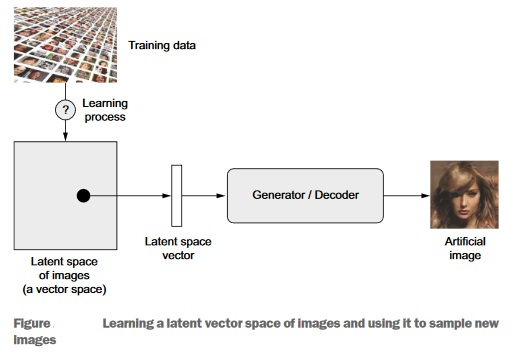


GANs and VAEs are two different strategies for learning such latent spaces of
image representations, each with its own characteristics. VAEs are great for learning latent spaces that are well structured, where specific directions encode a meaningful axis of variation in the data (see figure below). GANs generate images that can potentially be highly realistic, but the latent space they come from may not have as much structure and continuity.

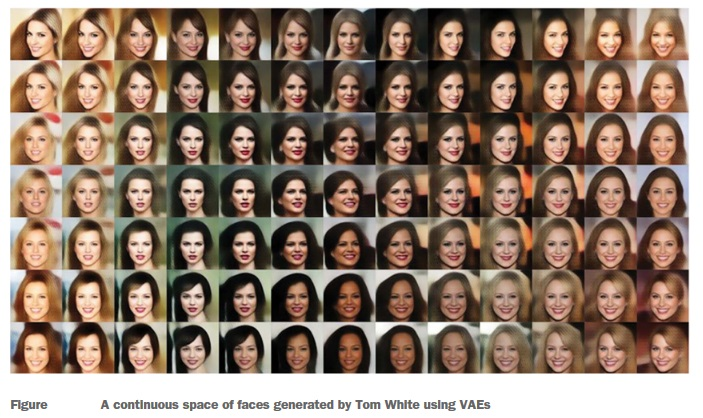

### Concept vectors for image editing

We already hinted at the idea of a concept vector when we covered word embeddings in chapter 11. The idea is still the same: given a latent space of representations, or an embedding space, certain directions in the space may encode interesting axes of variation in the original data. In a latent space of images of faces, for instance, there may be a smile vector, such that if latent point z is the embedded representation of a certain face, then latent point z + s is the embedded representation of the same face, smiling. Once you've identified such a vector, it then becomes possible to edit images by projecting them into the latent space, moving their representation in a meaningful way,
and then decoding them back to image space. There are concept vectors for essen-
tially any independent dimension of variation in image space—in the case of faces, you may discover vectors for adding sunglasses to a face, removing glasses, turning a male face into a female face, and so on. The figure below is an example of a smile vector, a concept vector discovered by Tom White, from the Victoria University School of Design in New Zealand, using VAEs trained on a dataset of faces of celebrities (the CelebA dataset).

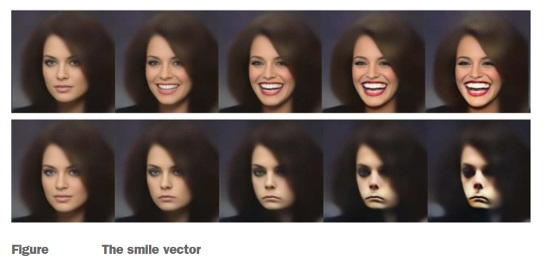

### Variational autoencoders

Variational autoencoders, simultaneously discovered by [Kingma and Welling in
December 2013](https://arxiv.org/abs/1312.6114) and [Rezende, Mohamed, and Wierstra in January 2014](https://arxiv.org/abs/1401.4082), are a kind of generative model that's especially appropriate for the task of image editing via concept vectors. They're a modern take on autoencoders (a type of network that aims to encode an input to a low-dimensional latent space and then decode it back) that mixes ideas from deep learning with Bayesian inference.

A classical image autoencoder takes an image, maps it to a latent vector space via an encoder module, and then decodes it back to an output with the same dimensions as the original image, via a decoder module (see figure below). It's then trained by using as target data the same images as the input images, meaning the autoencoder learns to reconstruct the original inputs. By imposing various constraints on the code (the output of the encoder), you can get the autoencoder to learn more-or-less-interesting latent representations of the data. Most commonly, you'll constrain the code to be low-dimensional and sparse (mostly zeros), in which case the encoder acts as a way to compress the input data into fewer bits of information.

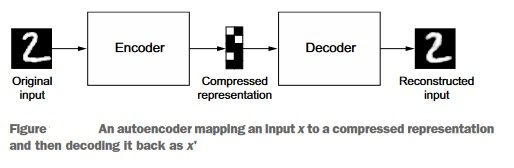

In practice, such classical autoencoders don't lead to particularly useful or nicely structured latent spaces. They're not much good at compression, either. For these reasons, they have largely fallen out of fashion. VAEs, however, augment autoencoders with a little bit of statistical magic that forces them to learn continuous, highly structured latent spaces. They have turned out to be a powerful tool for image generation.

A VAE, instead of compressing its input image into a fixed code in the latent
space, turns the image into the parameters of a statistical distribution: a mean and a variance. Essentially, this means we're assuming the input image has been generated by a statistical process, and that the randomness of this process should be taken into account during encoding and decoding. The VAE then uses the mean and variance parameters to randomly sample one element of the distribution, and decodes that element back to the original input (see figure 12.17). The stochasticity of this process improves robustness and forces the latent space to encode meaningful representations everywhere: every point sampled in the latent space is decoded to a valid output.

In technical terms, here's how a VAE works:

1.   An encoder module turns the input sample, `input_img`, into two parameters in a latent space of representations, `z_mean` and `z_log_variance`.
2.   You randomly sample a point `z` from the latent normal distribution that's
assumed to generate the input image, via `z = z_mean + exp(z_log_variance) *
epsilon`, where `epsilon` is a random tensor of small values.
3. A decoder module maps this point in the latent space back to the original
input image.



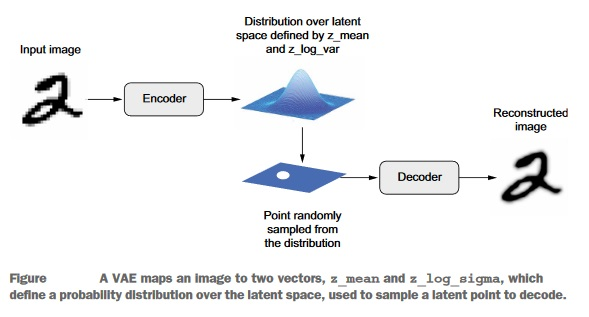

Because `epsilon` is random, the process ensures that every point that's close to the latent location where you encoded input_img (z-mean) can be decoded to something similar to input_img, thus forcing the latent space to be continuously meaningful. Any two close points in the latent space will decode to highly similar images. Continuity, combined with the low dimensionality of the latent space, forces every direction in the latent space to encode a meaningful axis of variation of the data, making the latent space very structured and thus highly suitable to manipulation via concept vectors.

The parameters of a VAE are trained via two loss functions: a reconstruction loss that forces the decoded samples to match the initial inputs, and a regularization loss that helps learn well-rounded latent distributions and reduces overfitting to the training data. Schematically, the process looks like this:

In [1]:
# Psuedocode
z_mean, z_log_variance = encoder(input_img)                                     # Encodes the input into mean and variance parameters
z = z_mean + exp(z_log_variance) * epsilon                                      # Draw a latent point using a small random epsilon
reconstructed_img = decoder(z)                                                  # Decodes z back to an image
model = Model(input_img, reconstructed_img)                                     # Instantiates the autoencoder model, which maps an image to its reconstruction

NameError: ignored

You can then train the model using the reconstruction loss and the regularization loss. For the regularization loss, we typically use an expression (the Kullback–Leibler divergence) meant to nudge the distribution of the encoder output toward a well-rounded normal distribution centered around 0. This provides the encoder with a sensible assumption about the structure of the latent space it's modeling.

Now let's see what implementing a VAE looks like in practice!

### Implementing a VAE with Keras

We're going to be implementing a VAE that can generate MNIST digits. It's going to have three parts:

- An encoder network that turns a real image into a mean and a variance in the
latent space.
- A sampling layer that takes such a mean and variance, and uses them to sample
a random point from the latent space
- A decoder network that turns points from the latent space back into images

The following listing shows the encoder network we'll use, mapping images to the
parameters of a probability distribution over the latent space. It's a simple convnet that maps the input image `x` to two vectors, `z_mean` and `z_log_var`. One important detail is that we use strides for downsampling feature maps instead of max pooling. The last time we did this was in the image segmentation example in chapter 9. Recall that, in general, strides are preferable to max pooling for any model that cares about information location—that is to say, where stuff is in the image—and this one does, since it will have to produce an image encoding that can be used to reconstruct a valid image.

**VAE encoder network**

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

latent_dim = 2                                                                  # Dimensionality of the latent space: a 2D plane

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)                             # The input image ends up being encoded in these two params
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)                       # z_mean and z_log_var
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

Its summary looks like this:

In [3]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 3136)                 0         ['conv2d_1[0][0]']            
                                                                                            

Next is the code for using `z_mean` and `z_log_var`, the parameters of the statistical distribution assumed to have produced `input_img`, to generate a latent space point `z`.

**Latent-space-sampling layer**

In [4]:
import tensorflow as tf

class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch_size, z_size))                  # Draw a batch of random normal vectors
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon                       # Apply the VAE sampling formula

The following listing shows the decoder implementation. We reshape the vector `z` to the dimensions of an image and then use a few convolution layers to obtain a final image output that has the same dimensions as the original `input_img`.

**VAE decoder network, mapping latent space points to images**

In [5]:
latent_inputs = keras.Input(shape=(latent_dim,))                                # Input where we'll feed x
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)                  # Produce the same number of coefficients that we had at the level of the Flatten layer in the encoder.
x = layers.Reshape((7, 7, 64))(x)                                               # Revert the Flatten layer of the encoder.
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x) # Revert the Conv2D layers of the encoder.
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)  # The output ends up with shape (28, 28, 1).
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

Its summary looks like this:

In [6]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         289 

Now let's create the VAE model itself. This is your first example of a model that isn't doing supervised learning (an autoencoder is an example of self-supervised learning, because it uses its inputs as targets). Whenever you depart from classic supervised learning, it's common to subclass the Model class and implement a custom `train_step()` to specify the new training logic, a workflow you learned about in chapter 7. That's what we'll do here.

**VAE model with custom `train_step()`**

In [9]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)                                              # We use these metrics to keep track of the loss averages over each epoch.
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):                                                          # We list the metrics in the metrics property to enable the model to reset
        self.reconstruction_loss_tracker,                                       # them after each epoch (or between multiple calls to fit()/evaluate()).
        return [self.total_loss_tracker,
                self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(                               # We sum the reconstruction loss over the spatial dimensions (axes 1 and 2)
                tf.reduce_sum(                                                  # and take its mean over the batch dimension.
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)) # Add the regularization term (Kullback–Leibler divergence).
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

Finally, we're ready to instantiate and train the model on MNIST digits. Because the loss is taken care of in the custom layer, we don't specify an external loss at compile time (`loss=None`), which in turn means we won't pass target data during training (as you can see, we only pass `x_train` to the model in `fit()`).

**Training the VAE**

In [10]:
import numpy as np

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)                        # We train on all MNIST digits, so we concatenate the training and test samples.
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)                # Note that we don’t pass a loss argument in compile(), since the loss is already part of the train_step().
vae.fit(mnist_digits, epochs=30, batch_size=128)                                # Note that we don’t pass targets in fit(), since train_step() doesn’t expect any.

11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/30


547/547 [==============================] - 38s 59ms/step - total_loss: 205.4821 - reconstruction_loss: 246.7346 - kl_loss: 3.1186
Epoch 2/30
547/547 [==============================] - 28s 52ms/step - total_loss: 169.4088 - reconstruction_loss: 191.5839 - kl_loss: 3.8157
Epoch 3/30
547/547 [==============================] - 29s 54ms/step - total_loss: 162.7016 - reconstruction_loss: 179.4274 - kl_loss: 3.7360
Epoch 4/30
547/547 [==============================] - 28s 51ms/step - total_loss: 158.3765 - reconstruction_loss: 172.8023 - kl_loss: 3.8533
Epoch 5/30
547/547 [==============================] - 29s 53ms/step - total_loss: 155.8766 - reconstruction_loss: 168.4266 - kl_loss: 3.9044
Epoch 6/30
547/547 [==============================] - 28s 52ms/step - total_loss: 154.2220 - reconstruction_loss: 165.2462 - kl_loss: 3.9296
Epoch 7/30
547/547 [==============================] - 28s 51ms/step - total_loss: 152.9609 - reconstruction_loss: 162.8340 - kl_loss: 3.9426
Epoch 8/30
547/547 [====

Once the model is trained, we can use the decoder network to turn arbitrary latent space vectors into images.

**Sampling a grid of images from the 2D latent space**

1/1 [==============================] - 0s 16ms/step


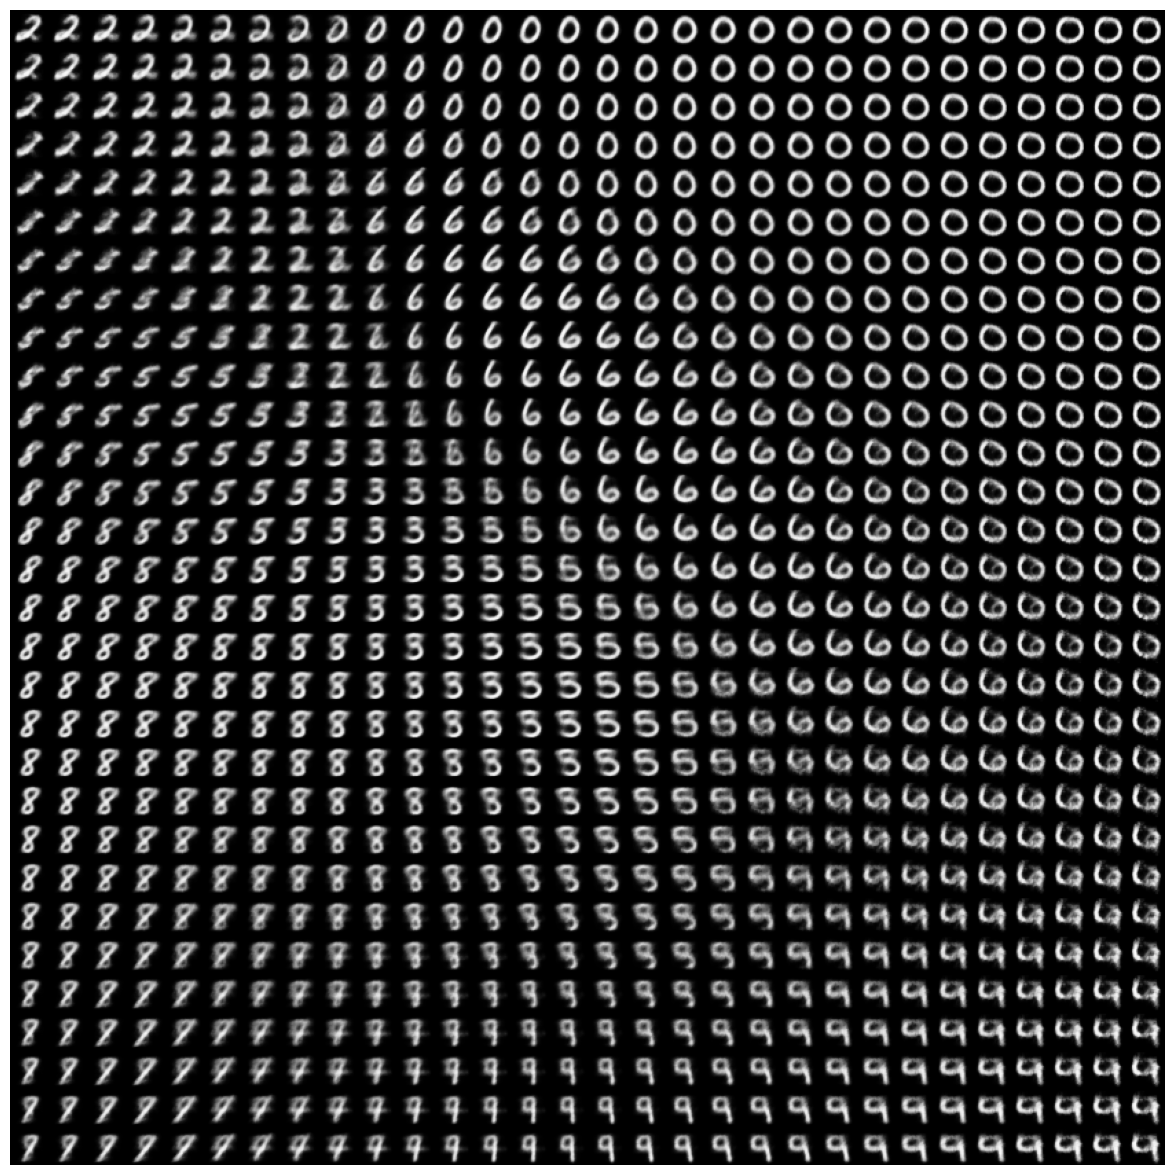

In [11]:
import matplotlib.pyplot as plt

n = 30                                                                          # We’ll display a grid of 30 × 30 digits (900 digits total).
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-1, 1, n)                                                  # Sample points linearly on a 2D grid.
grid_y = np.linspace(-1, 1, n)[::-1]

for i, yi in enumerate(grid_y):                                                 # Iterate over grid locations.
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])                                         # For each location, sample a digit and add it to our figure.
        x_decoded = vae.decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size,
        ] = digit

plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")

The grid of sampled digits (see figure below) shows a completely continuous distribution of the different digit classes, with one digit morphing into another as you follow a path through latent space. Specific directions in this space have a meaning: for example, there are directions for "five-ness," "one-ness," and so on.

.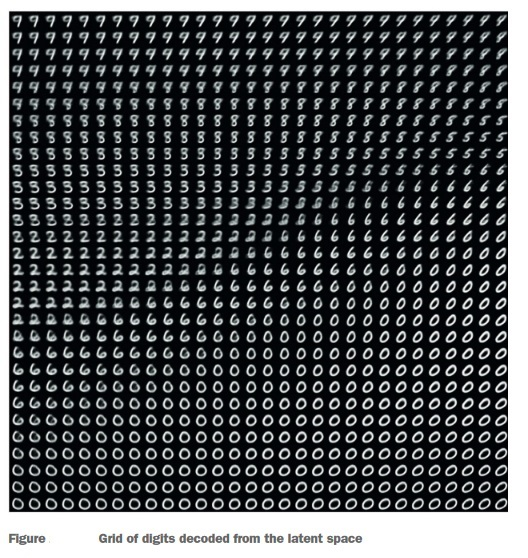

In the next section, we'll cover in detail the other major tool for generating artificial images: generative adversarial networks (GANs).

### Wrapping up

*   Image generation with deep learning is done by learning latent spaces that capture statistical information about a dataset of images. By sampling and decoding points from the latent space, you can generate never-before-seen images. There are two major tools to do this: VAEs and GANs.
*   VAEs result in highly structured, continuous latent representations. For this reason, they work well for doing all sorts of image editing in latent space: face swapping, turning a frowning face into a smiling face, and so on. They also work nicely for doing latent-space-based animations, such as animating a walk along a cross section of the latent space or showing a starting image slowly morphing into different images in a continuous way.
* GANs enable the generation of realistic single-frame images but may not induce
latent spaces with solid structure and high continuity.

Most successful practical applications I have seen with images rely on VAEs, but GANs have enjoyed enduring popularity in the world of academic research. You'll find out how they work and how to implement one in the next section.
